# Tutorial 5: Self-Supervised Learning

Often relevant data does not come with labels - human annotation is expensive.

Self-supervised learning (SSL) objectives allow us to learn useful features from unlabelled data.

SSL, combined with large-scale unlabelled internet-scraped data, has been a key contributor to many deep learning successes.

Large language model (e.g., ChatGPT) capabilities draw heavily from a 'next-word-prediction' objective on huge text datasets scraped from the internet.

Visual representations are often pretrained on unlabelled image data.

## Exercise 1: SSL on Unlabelled MNIST Data

In this first exercise, we create a toy setting to demonstrate the benefits that SSL on unlabelled data can provide.

The goal is to obtain a classifier for the MNIST dataset.

You only have access to 60 labelled examples, however - a very small number for deep learning. Fortunately, you do have access to a much larger dataset of 59,000 *unlabelled* examples.
This mimics the scenario where a large unlabelled internet dataset is available.

How could you leverage these unlabelled examples to improve the performance of your classifier?

One possibility, which you will attempt in this tutorial, is to use an SSL objective to pretrain useful visual features on the unlabelled dataset.

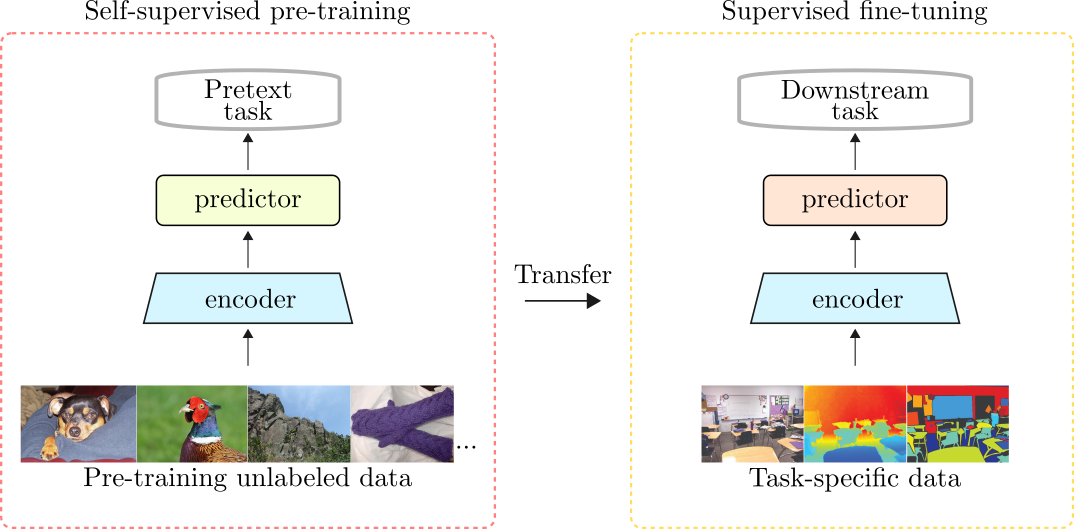

In [ ]:
# !pip install torchinfo

In [ ]:
# Import libraries
from torchinfo import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from transformers import CLIPModel, CLIPProcessor
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### DO NOT CHANGE
UNLABELED_RATIO = 0.999
USE_FASHION_MNIST = False
###

# Device selection with error handling
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

device = get_device()
print(f"Using device: {device}")

ModuleNotFoundError: No module named 'transformers'

### Functions

Lets prepare some functions that will help with our experiments.

#### Data

The MNIST dataset is fully labelled by default. Lets create a function that removes the majority of the labels to create our toy setting.

In [4]:
def load_and_split_mnist(unlabeled_ratio=UNLABELED_RATIO, use_fashion_mnist=USE_FASHION_MNIST):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    dataset_class = datasets.FashionMNIST if use_fashion_mnist else datasets.MNIST

    full_dataset = dataset_class(root='./data', train=True, download=True, transform=transform)
    test_dataset = dataset_class(root='./data', train=False, download=True, transform=transform)

    dataset_size = len(full_dataset)
    unlabeled_size = int(dataset_size * unlabeled_ratio)
    labeled_size = dataset_size - unlabeled_size

    unlabeled_dataset, labeled_dataset = torch.utils.data.random_split(full_dataset, [unlabeled_size, labeled_size])

    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=True)
    labeled_loader = DataLoader(labeled_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    dataset_name = "Fashion MNIST" if use_fashion_mnist else "MNIST"
    print(f"Using {dataset_name} dataset")
    print(f"Unlabeled dataset size: {len(unlabeled_dataset)}")
    print(f"Labeled dataset size: {len(labeled_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    return unlabeled_loader, labeled_loader, test_loader

NameError: name 'UNLABELED_RATIO' is not defined

#### Model Architectures

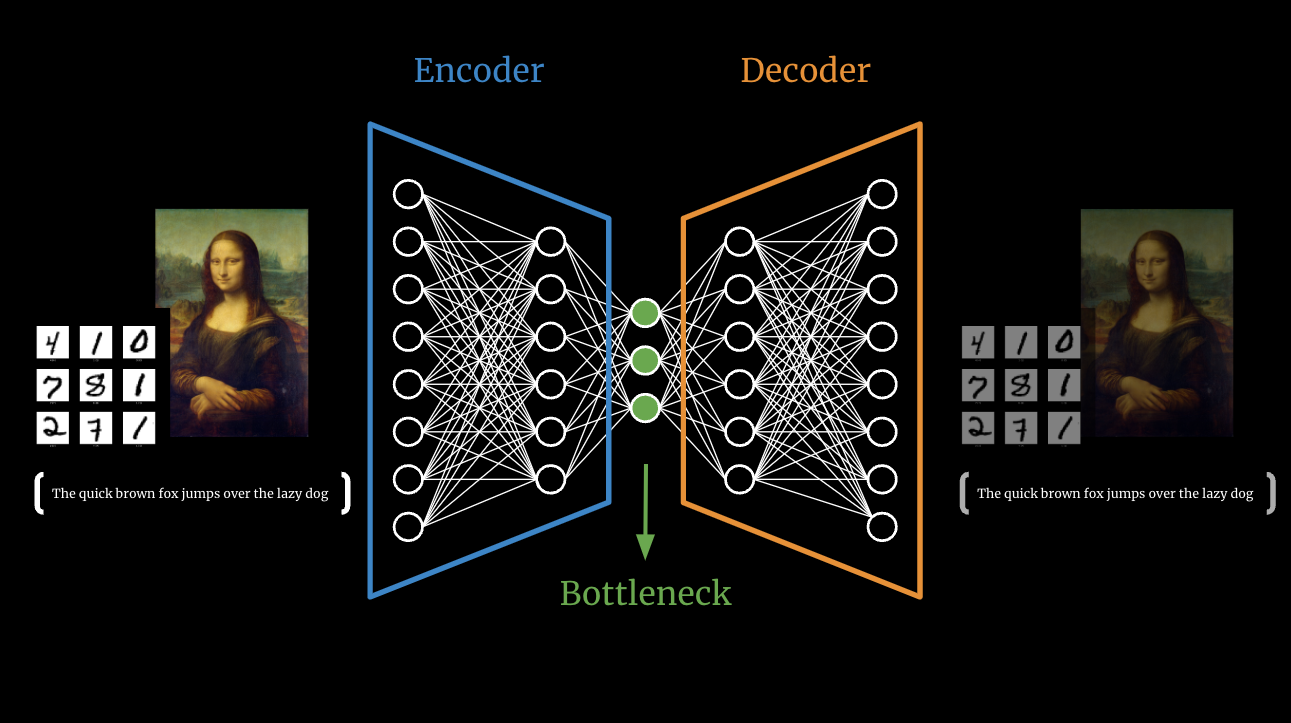

We will pretrain using an auto-encoder (AE) as our SSL objective.

We will then use the visual representations from the pretrained encoder to initialize the visual represntations of our MNIST classifier.

Lets design our networks to fit this format.

('recon' is short for reconstruction)

In [ ]:
# Define encoder for the AE and for our classifiers visual features
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

        self.encoder = # INSERT (hint: try to match the decoder)
        self.fc = # INSERT

    def forward(self, x):
        h = self.encoder(x)
        return self.fc(h)

# Define Decoder for the AE
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear_up = nn.Linear(latent_dim, 7*7*32)
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1), # 7x7
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2), # 14x14
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2), # 28x28
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        z = self.linear_up(z)
        z = z.view(-1, 32, 7, 7)
        z = self.decoder(z)
        return z

# Define AE
class AE(nn.Module):
    def __init__(self, latent_dim):
        super(AE, self).__init__()

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon, z

# Define classifier which can take in an encoder and use its visual features
class Classifier(nn.Module):
    def __init__(self, encoder, latent_dim, hidden_dims=[128], num_classes=10, freeze_body=False):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.freeze_body = freeze_body

        # Build classifier layers
        layers = []
        input_dim = latent_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim

        # The input_dim here will be either the last hidden_dim or latent_dim if no hidden layers
        layers.append(nn.Linear(input_dim, num_classes))  # Output layer

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        if self.freeze_body:
            with torch.no_grad():
                z = self.encoder(x)
        else:
            z = self.encoder(x)
        return self.classifier(z)

#### Training and Evaluation

In [ ]:
# Funtion to evaluate the AE
def evaluate_ae(model, test_loader):
    model.eval()
    test_loss = 0
    num_samples = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, z = model(data)
            loss = ae_loss_function(recon, data)
            test_loss += loss.item()
            num_samples += data.size(0)

    avg_loss = test_loss / num_samples
    print(f'Test Epoch.... '
          f'Total: {avg_loss:.4f}')
    return avg_loss

# Reconstruct images using the AE
def reconstruct_examples(model, test_loader, num_examples=8):
    model.eval()
    # Get a random batch of data
    data, _ = next(iter(test_loader))

    # Randomly select num_examples from this batch
    indices = torch.randperm(len(data))[:num_examples]
    data = data[indices].to(device)

    fig, axes = plt.subplots(2, num_examples, figsize=(2*num_examples, 5))

    with torch.no_grad():
        recon, z = model(data)

        for i in range(num_examples):
            original = data[i].cpu()
            reconstruction = recon[i].cpu()

            axes[0, i].imshow(original.squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')

            axes[1, i].imshow(reconstruction.squeeze(), cmap='gray')
            axes[1, i].set_title('Reconstruction')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Map the AE features into a low-dimensional space the can be visualized using TSNE
# (If the data seems visually well disentangled,
#  the features will likely useful for the classification task)
# https://www.datacamp.com/tutorial/introduction-t-sne
def plot_tsne(model, test_loader, num_samples=1000):
    model.eval()
    latent_vectors = []
    labels = []
    sample_count = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            z = model.encode(data)
            latent_vectors.append(z.cpu().numpy())
            labels.extend(target.numpy())
            sample_count += data.size(0)
            if sample_count > num_samples:
                break

    latent_vectors = np.concatenate(latent_vectors, axis=0)

    tsne = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of latent space')
    plt.show()

# Plot AE losses
def plot_ae_losses(train_losses, test_losses, eval_interval):
    epochs = len(train_losses)
    eval_epochs = range(eval_interval, epochs + 1, eval_interval)

    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle('AE Losses Over Time')

    ax.plot(range(1, epochs + 1), train_losses, label='Train')
    ax.plot(eval_epochs, test_losses, label='Test')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Total Loss')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# AE loss function
def ae_loss_function(recon_x, x):
    # Reconstruction loss
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

    return recon_loss

# AE training epoch
def train_ae(ae_model, train_loader, optimizer, epoch):
    ae_model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Train Epoch: {epoch}. '
          f'Total Loss: {avg_loss:.4f}')
    return avg_loss

# Classifier training epoch
def train_classifier(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f'Train Epoch: {epoch}. Average loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

# Classifier evaluation
def evaluate_classifier(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.cross_entropy(output, target, reduction='sum').item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / total
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return test_loss, accuracy

# Full training and evaluation loop for the classifier
def train_and_evaluate_classifier_loop(classifier, optimizer, labeled_loader, test_loader, epochs, eval_interval, name=""):
    train_accuracies = []
    test_accuracies = []

    print(f"Starting {name} Classifier training...")
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_classifier(classifier, labeled_loader, optimizer, epoch)
        train_accuracies.append(train_acc)

        if epoch % eval_interval == 0:
            print(f"Evaluating {name} Classifier on test set (Epoch {epoch})...")
            test_loss, test_acc = evaluate_classifier(classifier, test_loader)
            test_accuracies.append(test_acc)

    print(f"{name} Classifier training complete!")

    # Plotting with fixed y-axis range and custom title
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot([i * eval_interval for i in range(1, len(test_accuracies) + 1)], test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'< {name} >: Classification Accuracy')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 100)  # Set y-axis range from 0 to 100
    plt.show()

### Load Data and Hyperparameters

In [ ]:
# Set hyperparameters
BATCH_SIZE = 64
AE_EPOCHS = 10 # Epochs to pretrain AE for
CLASSIFY_EPOCHS = 20 # Epochs to train classifier for
CLIP_CLASSIFY_EPOCHS = 20 # EPochs to train CLIP-initialized classifier for
LEARNING_RATE = 1e-3
LATENT_DIM = 64 # Bottleneck size of the AE
EVAL_INTERVAL = 5 # Evaluate every N epochs

Load the dataset and note the quantities of data in each dataset.

In [ ]:
# Load dataset
unlabeled_loader, labeled_loader, test_loader = load_and_split_mnist()

### Pretrain Features via AE on Unlabelled Data

In [ ]:
# Initialize AE
print("\n\nInitializing AE...")
########################################################################
#                              YOUR CODE HERE                          #
########################################################################
ae = # INSERT
ae_optimizer = # INSERT

In [ ]:
# Pretrain AE on unlabelled data

train_losses = []
test_losses = []

print("Starting AE training...")
for epoch in range(1, AE_EPOCHS + 1):
    avg_loss = train_ae(ae, unlabeled_loader, ae_optimizer, epoch)
    train_losses.append(avg_loss)

    if epoch % EVAL_INTERVAL == 0:
        print("Evaluating AE on test set...")
        test_loss = evaluate_ae(ae, test_loader)
        test_losses.append(test_loss)

        print("Reconstructing random examples...")
        reconstruct_examples(ae, test_loader)

        print("Plotting t-SNE visualization...")
        plot_tsne(ae, test_loader)

# Plot the losses
plot_ae_losses(train_losses, test_losses, EVAL_INTERVAL)

print("AE training complete!")

### Train Classifier on Labelled Data using Pretrained Features

#### Baseline: Randomly Initialized Features

Before we try using pretrained features, as always we should establish a baseline.

In this case, the simplest baseline would be a standard model trained from scratch on the labelled data - i.e., a model with randomly initialized features.

In [ ]:
# Initialize a classifier with random features
########################################################################
#                              YOUR CODE HERE                          #
########################################################################
scratch_encoder = # INSERT
classifier = # INSERT
classifier_optimizer = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)

# Train classifier
train_and_evaluate_classifier_loop(classifier, classifier_optimizer, labeled_loader, test_loader, CLASSIFY_EPOCHS, EVAL_INTERVAL, name="Randomly_Initialized")

#### Frozen AE Features

When using pretrained features, you can either keep them frozen, or you can update them with the finetuning objective.

Keeping frozen: This may be a good option if you have high-quality pretrained features that generalize well which you do not wish to override/forget via a small finetuning phase

Finetuning pretrained features: This may be a good option if your downstream task is niche/specific, and so requires features specifically optimized for it.

Lets first try using frozen features from the pretrained AE.

In [ ]:
# Make a copy of the AE encoder
ssl_encoder = Encoder(LATENT_DIM).to(device)
ssl_encoder.load_state_dict(ae.encoder.state_dict())

# Freeze encoders parameters
########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Initialize new classifier
########################################################################
#                              YOUR CODE HERE                          #
########################################################################
ssl_classifier = # INSERT
ssl_classifier_optimizer = # INSERT

# Train new classifier
train_and_evaluate_classifier_loop(ssl_classifier, ssl_classifier_optimizer, labeled_loader, test_loader, CLASSIFY_EPOCHS, EVAL_INTERVAL, name="SSL_Pretrained_Frozen")

#### Unfrozen AE Features

Now lets try finetuning the AE features while training the classifier.

In [ ]:
# Copy AE encoder
########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Initialize classifier with unfrozen features
########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Train classifier
train_and_evaluate_classifier_loop(ssl_classifier, ssl_classifier_optimizer, labeled_loader, test_loader, CLASSIFY_EPOCHS, EVAL_INTERVAL, name="SSL_Pretrained_Trainable")


### Analysis and Extensions

- Did the SSL pretrained features help?
  - Why? Why not?
  - Which setup worked best?
- What could you change to improve performance?
  - This could include hyperparameters, architectures etc.
  - This could also include the pretraining objective. AE is a very simple objective. VAE would be a natural extension. There are [other options](https://viso.ai/deep-learning/self-supervised-learning-for-computer-vision/#:~:text=The%20objective%20is%20to%20minimize,clean%20images%20from%20noisy%20inputs.), including contrastive learning with [SimCLR](https://arxiv.org/abs/2002.05709).
  - If you observed overfitting, maybe this could be addressed
  - One interesting extension could be to try ['semi-supervised' learning](https://www.altexsoft.com/blog/semi-supervised-learning/) - where you use your trained classifier to provide 'pseudo' labels for the unlabelled data, then train on these pseudo-labels, then repeat this process.
- Can you think of other ways you could leverage the unlabelled data to try improve classification performance on the labelled test data?

Feel free to run exploratory experiments and extensions to help you answer these questions!

In [ ]:
#################################################################
# Insert code to improve performance (or modify the above code) #
#################################################################

## Exercise 2: Pretrained Models on CIFAR-10

Here we will demonstrate the benefit of using features from a model pretrained on large-scale data using SSL.

Since MNIST is very easy, SSL pretrained models don't add much extra value. As such, lets use a more complex dataset:

[OxfordIIITPet](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### Prepare Dataset

In [ ]:
# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = OxfordIIITPet(root='./data', split='trainval', transform=train_transform, download=True)
test_dataset = OxfordIIITPet(root='./data', split='test', transform=test_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

### Training Function

In [ ]:
# Training function
def train_model(model, criterion, optimizer, num_epochs=5):
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%')

    return history

### Train a Baseline

In [ ]:
# Define simple CNN for baseline
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 37)  # 37 pet classes
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Train baseline model
print("Training baseline model...")
baseline_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
baseline_history = train_model(baseline_model, criterion, optimizer, num_epochs=5)

### Train with SSL Pretrained Features

Lets use a model whose features are pretrained using the [DINO](https://arxiv.org/pdf/2104.14294) SSL objective.

In [ ]:
# Load and modify SSL model
print("\nTraining SSL pretrained model...")

# Load DINO ResNet50 from Facebook's official implementation
ssl_model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50', pretrained=True)

# We need to add our classifier after the avgpool layer
# The avgpool will give us 2048-dimensional features (from the last layer's channels)
ssl_model.fc = nn.Linear(2048, 37)  # Replace Identity with our classifier

# Freeze all layers except the final classifier
for name, param in ssl_model.named_parameters():
    if 'fc' not in name:  # Freeze everything except the final classifier
        param.requires_grad = False

ssl_model = ssl_model.to(device)
optimizer = optim.Adam(ssl_model.fc.parameters(), lr=0.0001)
pretrained_history = train_model(ssl_model, criterion, optimizer)

In [ ]:
# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(baseline_history['train_acc'], label='Baseline Train')
plt.plot(baseline_history['val_acc'], label='Baseline Val')
plt.plot(pretrained_history['train_acc'], label='Pretrained Train')
plt.plot(pretrained_history['val_acc'], label='Pretrained Val')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(baseline_history['train_loss'], label='Baseline')
plt.plot(pretrained_history['train_loss'], label='Pretrained')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Analysis and Extensions

- Which approach worked best?
- What happens if you unfreeze the pretrained parameters?
- Can you think of other improvements? (e.g., address overfitting)